### Data Loading

First, make sure that you have gained access to the CiteULike dataset (`raw-data.csv`) and placed it in the `data/CiteULike` directory. It is available [here](http://www.citeulike.org/faq/data.adp).

In [1]:
import pandas as pd
import numpy as np
tab = pd.read_csv('/data/CiteULike/raw-data.csv', encoding='latin-1')

In [2]:
tab.head()

,doc.id,title,citeulike.id,raw.title,raw.abstract
0,1,the metabolic world of escherichia coli is not...,42.0,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...
1,2,reverse engineering of biological complexity,43.0,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...
2,3,exploring complex networks,44.0,Exploring complex networks,"The study of networks pervades all of science,..."
3,4,comparative assessment of largescale data sets...,46.0,Comparative assessment of large-scale data set...,Comprehensive protein protein interaction maps...
4,5,navigation in a small world,47.0,Navigation in a small world,The small-world phenomenon â the principle t...


### Abstracts embeddings

In [3]:
from preprocessing import TextPreprocessor
prep = TextPreprocessor(glove_components=300, min_df=5, max_df=0.4)
processed_articles = prep.fit(tab['raw.abstract'], window=10, epochs=100)
embedded_articles = prep.idf_embed(processed_articles)

Cleaning 16980 inputs...Done!
Training Tf-idf model...Done!
Training Glove model...Done!
Empty embedding

 è¿å¹´ï¼æ¹ç­ããé æ³ã«åºã¥ãå¼·åå­¦ç¿æ³ã®ä¸ç¨®ã§ããNatural Actor-Criticæ³ï¼NACï¼ãææ¡ãããï¼ãã®ææ³ã¯ï¼actorã®å­¦ç¿ã«èªç¶æ¹ç­ããé æ³ï¼criticã®å­¦ç¿ã«lstd-qî»æ³ãç¨ãããã®ã§ï¼é«æ¬¡å ã®åå­¦ç³»ã«å¯¾ããæ¯è¼çå¹çã®è¯ãã¢ãã«ããªã¼å¼·åå­¦ç¿æ³ã¨ãã¦æ³¨ç®ããã¦ããï¼ããããªããï¼nacã¯æ¹ç­ãªã³åï¼ããªãã¡ç¾å¨ã®æ¹ç­ã«ä¾å­ããå­GPEç¿æ³ã§ãããã¨ã«ããï¼äºã¤ã®åé¡ç¹ãããï¼ç¬¬ä¸ã«ï¼æ¹ç­ããé ã®æ¨å®ã«ã¯ï¼ç¾å¨ã®æ¹ç­ã®ãã¨ã§çæãããµã³ãã«ç³»åãå¿ è¦ã§ããï¼éå»ã®æ¹ç­ã®ãã¨ã§çæããç³»åã¯ç¨ãããã¨ãã§ããªãï¼ç¬¬äºã«ï¼å¼·åå­¦ç¿ã«ããã¦éè¦ãªåé¡ã§ããæ¢ç´¢ã»æ¾åã®å¶å¾¡ã®åCARDINALå ¥ã«ã¯å¤§ããªå¶ç´ãããï¼ãããã®åé¡ãè§£æ±ºãããã

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(embedded_articles)
embedded_articles = ss.transform(embedded_articles)

In [5]:
from sklearn.decomposition import PCA
pca_model = PCA(50)
pca_model.fit(embedded_articles)
embedded_articles = pca_model.transform(embedded_articles)

### Evaluation of the algorithm

In [6]:
N_ARTICLES = 16980
N_USERS = 5551

First, we create a holdout test set. The remaining records are split into train-test pairs where splits differ in the number of training examples per user. We range the number of training items per user from 1 to 5 as it is done in the CRAE [paper](http://www.wanghao.in/paper/NIPS16_CRAE.pdf).

In [7]:
from data_split import train_test_folds

In [8]:
train_test_folds(
    data_path='/data/CiteULike/user-info.csv',
    output_dir='/data/CiteULike/folds',
    user_id='user.id', doc_id='doc.id', train_size=0.8,
    train_sizes=range(1, 6), full_seed=42, partial_seed=42
)

In [9]:
from remap_utils import _file_to_list
from models import BlockCoordinateAscent
from metrics import recall_lift

#### Various Number of training examples

We evaluate how does the algoritm perform when we change the number of training items per user (parameter P in the original paper) with the number of recommended items per user (parameter M in the original paper) remaining fixed at 300.

In [10]:
epochs_dict = {
    1: 2,
    2: 2,
    3: 2,
    4: 3,
    5: 3
}  # how many epochs depending on number of training items per user
M = 300  # recall@M - metric parameter

In [11]:
train_metrics = []
test_metrics = []
for n_train_ones in range(1, 6):
    train_ones = _file_to_list(
        filename='/data/CiteULike/folds/train_training_size_{}.csv'.format(n_train_ones),
        n_users=N_USERS)
    test_ones = _file_to_list(
        filename='/data/CiteULike/folds/valid_training_size_{}.csv'.format(n_train_ones),
        n_users=N_USERS)
    model = BlockCoordinateAscent(train_ones, embedded_articles.copy())
    model.fit(n_epochs=epochs_dict[n_train_ones])
    predictions = model.predict()
    test_result = recall_lift(predictions, train_ones, test_ones, M)
    train_result = recall_lift(predictions, [[]] * len(train_ones), train_ones, M)
    test_metrics.append(test_result)
    train_metrics.append(train_result)
    print('Number of ones per user:', n_train_ones, test_result, train_result)

Number of ones per user: 1 Evaluation(recall=0.21750220693430833, lift=12.309899905125405) Evaluation(recall=1.0, lift=56.600000000000016)
Number of ones per user: 2 Evaluation(recall=0.2856865819833242, lift=16.167955963042928) Evaluation(recall=1.0, lift=56.600000000000016)
Number of ones per user: 3 Evaluation(recall=0.33529673447161484, lift=18.974442203748684) Evaluation(recall=0.9998799015192458, lift=56.593202425989325)
Number of ones per user: 4 Evaluation(recall=0.37043884518245707, lift=20.961899452724637) Evaluation(recall=0.9999549630697172, lift=56.597450909746)
Number of ones per user: 5 Evaluation(recall=0.4113493554739759, lift=23.2755176972358) Evaluation(recall=0.9999279409115476, lift=56.595921455593604)


In [12]:
recalls = [metric.recall for metric in test_metrics]

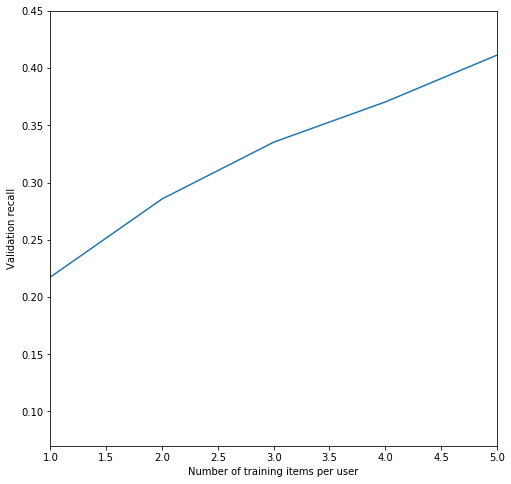

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.xlim((1, 5))
plt.ylim((0.07, 0.45))
plt.xlabel('Number of training items per user')
plt.ylabel('Validation recall')
_ = plt.plot(range(1, 6), recalls)

Now, let's see how that compares with the benchmark performed in the CRAE paper. (Notice the Recall scale)

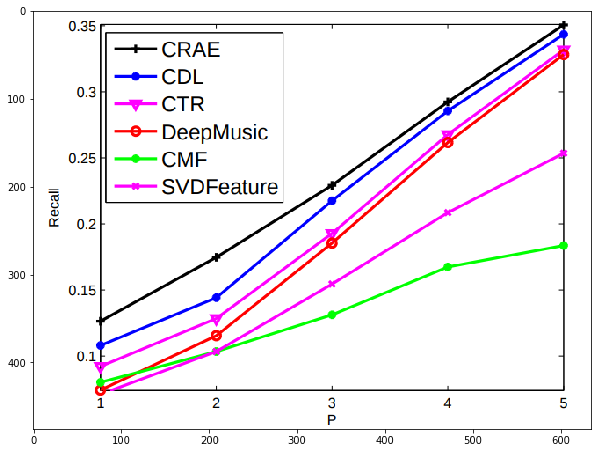

In [18]:
img = plt.imread('/data/CiteULike/crae_benchmarks.png')
plt.figure(figsize=(10, 10))
_ = plt.imshow(img)

#### Various number of recommended items

We will check how the performance changes when we change the number of recommended items per user (M=50,100,150,...,300) with the number of training items (P) remaining fixed at 1.

In [20]:
train_ones = _file_to_list(filename='/data/CiteULike/folds/train_training_size_1.csv', n_users=N_USERS)
test_ones = _file_to_list(filename='/data/CiteULike/folds/valid_training_size_1.csv', n_users=N_USERS)
model = BlockCoordinateAscent(train_ones, embedded_articles.copy())
model.fit(n_epochs=epochs_dict[1])
predictions = model.predict()
test_result = recall_lift(predictions, train_ones, test_ones, range(50,301, 50))
train_result = recall_lift(predictions, [[]] * len(train_ones), train_ones, range(50,301, 50))

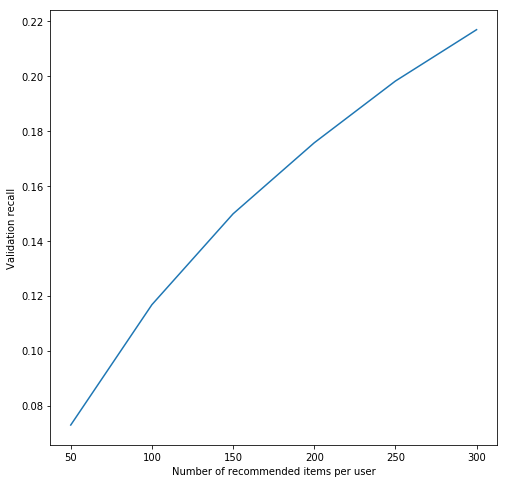

In [22]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of recommended items per user')
plt.ylabel('Validation recall')
_ = plt.plot(range(50,301, 50), test_result.recall)

Again, we compare with the CRAE benchmark

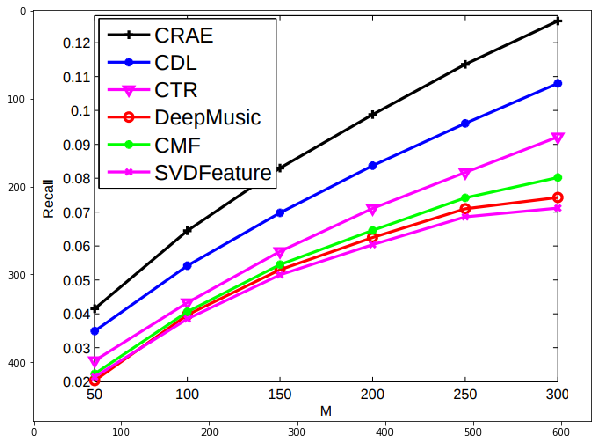

In [23]:
img = plt.imread('/data/CiteULike/crae_varying_M.png')
plt.figure(figsize=(10, 10))
_ = plt.imshow(img)